In [ ]:
import re
import random
import time
import math
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
plt.style.use('default')

CHECKPOINT_DIR = "checkpoints/" # Directory to save all models to
    
TRAIN_ALL_MODELS = False # Whether to overwrite saved models by retraining or not (will be skipped otherwise)

USE_SMALLER_DATASET_SIZE = True # If smaller dataset should be used. If yes, the next parameter (DATASET_DIVISION_FACTOR) will determine by how much the dataset is decreased
DATASET_DIVISION_FACTOR = 1

if USE_SMALLER_DATASET_SIZE:
    CHECKPOINT_DIR += "small_dataset_"+str(DATASET_DIVISION_FACTOR)+"/"
    
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

In [ ]:
# this function reads in a textfile and fixes an issue with \\
def filereader(path): 
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

In [ ]:
# Let's look at a data point.
# If you look closely you will find that this is a flattened tree, 
# with sentiment scores at every node, and words as the leaves.
s = next(filereader("/content/dev.txt"))
print(s)

(0 (0 sürükleyici) (0 (0 (0 bir) (0 (0 (0 bilimkurgu) (0 (0 romanı) (0 (0 .) (0 (0 romanda) (0 uzaydaki))))) (0 (0 (0 diğer) (0 gezegenlerde)) (0 (0 insan) (0 (0 ırkının) (0 (0 uzaylı) (0 (0 ırklara) (0 (0 karşı) (0 (0 verdiği) (0 (0 kolonileşme) (0 (0 savaşı) (0 (0 ve) (0 (0 bu) (0 (0 savaşa) (0 (0 katılan) (0 (0 yaşlı) (0 (0 bir) (0 (0 adamın) (0 (0 bambaşka) (0 (0 ikinci) (0 (0 bir) (0 (0 hayatı) (0 (0 ele) (0 alınmış)))))))))))))))))))))))) (0 .)))


In [ ]:
# We can use NLTK to print the tree structure more nicely
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

                                                                 0                                                                                                                                                                            
      ___________________________________________________________|____________________________________________________________________                                                                                                         
     |                                                                                                                                0                                                                                                       
     |                        ________________________________________________________________________________________________________|_____________________________________________________________________________________________________   
     |                       0            

You can see the sentiment annotations here **at every node**! 1 is very negative, 5 is very positive. For now, we will only use the sentiment score at the **root node**; this is the score for the complete sentence.

In [ ]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()
 
# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['sürükleyici', 'bir', 'bilimkurgu', 'romanı', '.', 'romanda', 'uzaydaki', 'diğer', 'gezegenlerde', 'insan', 'ırkının', 'uzaylı', 'ırklara', 'karşı', 'verdiği', 'kolonileşme', 'savaşı', 've', 'bu', 'savaşa', 'katılan', 'yaşlı', 'bir', 'adamın', 'bambaşka', 'ikinci', 'bir', 'hayatı', 'ele', 'alınmış', '.']
31


In [ ]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [ ]:
# Now let's first see how large our data sets are.
for path in ("/content/train.txt", "/content/dev.txt", "/content/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

/content/train.txt  979
/content/dev.txt  141
/content/test.txt  280


In [ ]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])

   
def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    if(len(tokens) <= 100):
      tree = Tree.fromstring(line)  # use NLTK's Tree
      label = int(line[1])
      trans = transitions_from_treestring(line)
      yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)

# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("/content/train.txt", lower=LOWER))
dev_data = list(examplereader("/content/dev.txt", lower=LOWER))
test_data = list(examplereader("/content/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 954
dev 140
test 277


In [ ]:
print(test_data)

[Example(tokens=['kitabın', 'ismine', 'bakınca', 'romantik', 'duygusal', 'bir', 'aşk', 'hikayesi', 'olduğunu', 'düşünmüştüm', ',', 'çok', 'acı', 'bir', 'hikaye', 'ama', 'kitabın', 'başından', 'sonuna', 'kadar', 'bir', 'hayat', 'kadının', 'yaşadığı', 'herşey', 'en', 'ufak', 'ayrıntısıyla', 'anlatılmış', ',', 'argo', 'aşırı', 'derecede', 'var', ',', 'çoğu', 'yerde', 'midem', 'bulandı', ',', 'aynı', 'hikaye', 'daha', 'güzel', 'bir', 'dille', 'yazılabilirdi', ',', 'ayrıca', 'hikayeye', 'bakarsam', 'sevdiği', 'kadının', 'aynı', 'hayatı', 'sürmesine', 'izin', 'veren', 'bir', 'erkek', 'var', 'ortada', ',', 'o', 'da', 'tartışılır', 'yani', ',', 'sadece', 'gerçek', 'olduğu', 'için', 'sonunu', 'merak', 'ettiğimden', 'okudum', 'sonra', 'çöpe', 'attım', ',', 'kitaplığımda', 'bulunmasını', 'istemedim', ',', 'kitabı', 'okuduktan', 'sonra', 'erkeklerden', 'nefret', 'eder', 'duruma', 'bile', 'gelebilirsiniz', '.'], tree=Tree('0', [Tree('0', [Tree('0', [Tree('0', ['kitabın']), Tree('0', [Tree('0', ['is

Let's check out an example object.

In [ ]:
example = dev_data[0]
print("First train example:", example)
print("First train example tokens:", example.tokens)
print("First train example label:",  example.label)

First train example: Example(tokens=['sürükleyici', 'bir', 'bilimkurgu', 'romanı', '.', 'romanda', 'uzaydaki', 'diğer', 'gezegenlerde', 'insan', 'ırkının', 'uzaylı', 'ırklara', 'karşı', 'verdiği', 'kolonileşme', 'savaşı', 've', 'bu', 'savaşa', 'katılan', 'yaşlı', 'bir', 'adamın', 'bambaşka', 'ikinci', 'bir', 'hayatı', 'ele', 'alınmış', '.'], tree=Tree('0', [Tree('0', ['sürükleyici']), Tree('0', [Tree('0', [Tree('0', ['bir']), Tree('0', [Tree('0', [Tree('0', ['bilimkurgu']), Tree('0', [Tree('0', ['romanı']), Tree('0', [Tree('0', ['.']), Tree('0', [Tree('0', ['romanda']), Tree('0', ['uzaydaki'])])])])]), Tree('0', [Tree('0', [Tree('0', ['diğer']), Tree('0', ['gezegenlerde'])]), Tree('0', [Tree('0', ['insan']), Tree('0', [Tree('0', ['ırkının']), Tree('0', [Tree('0', ['uzaylı']), Tree('0', [Tree('0', ['ırklara']), Tree('0', [Tree('0', ['karşı']), Tree('0', [Tree('0', ['verdiği']), Tree('0', [Tree('0', ['kolonileşme']), Tree('0', [Tree('0', ['savaşı']), Tree('0', [Tree('0', ['ve']), Tree('0

#### Vocabulary 



In [ ]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""
  
  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1
    
  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)    
    
  def build(self, min_freq=0):
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)   
    
    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

Token vocabulary



In [ ]:
# This process should be deterministic and should have the same result 
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 7314


#### Sentiment label vocabulary

In [ ]:
# Now let's map the sentiment labels 1-5 
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
i2t

['very negative', 'negative', 'neutral', 'positive', 'very positive']

In [ ]:
# Now let's map the sentiment labels 0-1 
i2t = ["negative","positive"]
i2t

['negative', 'positive']

In [ ]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i+1 for p, i in zip(i2t, range(len(i2t)))})
t2i

OrderedDict([('very negative', 1),
             ('negative', 2),
             ('neutral', 3),
             ('positive', 4),
             ('very positive', 5)])

In [ ]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
t2i

OrderedDict([('negative', 0), ('positive', 1)])

## Installing PyTorch

In [ ]:
# http://pytorch.org/
from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
import torch
from torch import optim
from torch import nn

In [ ]:
# this should result in the PyTorch version
torch.__version__

'1.8.0+cu101'

In [ ]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(0)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)


In [ ]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for 1 example
  """
  
  # vocab returns 0 if the word is not there
  x = [[vocab.w2i.get(t, 0) for t in example.tokens]]
  
  x = torch.LongTensor(x)
  x = x.to(device)
  
  y = torch.LongTensor([example.label])
  y = y.to(device)
  
  return x, y

In [ ]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
    """Accuracy of a model on given data set."""
    correct = 0
    total = 0
    preds = list()
    model.eval()  # disable dropout (explained later)

    for example in data:

        # convert the example input and label to PyTorch tensors
        x, target = prep_fn(example, model.vocab)

        # forward pass
        # get the output from the neural network for input x
        with torch.no_grad():
            logits = model(x)

        # get out the prediction
        prediction = logits.argmax(dim=-1)

        # add the number of correct predictions to the total correct
        correct += (prediction == target).sum().item()
        total += 1
        preds.append(prediction[0].item())
        
        del x
        del target
        torch.cuda.empty_cache()  

    return correct, preds, correct / float(total)

In [ ]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  indices = list(range(len(data)))
  if shuffle:
    print("Shuffling training data")
    random.shuffle(indices)  # shuffle training data each epoch
  for index in indices:
    yield data[index]

In [ ]:
def train_model(model, optimizer, num_iterations=500, 
                print_every=10, eval_every=100,
                batch_fn=get_examples, 
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None,
                file_prefix=None, dataset_train=None):
    """Train a model."""  
    iter_i = 0
    train_loss = 0.
    print_num = 0
    start = time.time()
    criterion = nn.CrossEntropyLoss() # loss function
    best_eval = 0.
    best_iter = 0

    if not file_prefix:
        checkpoint_path = CHECKPOINT_DIR + "{}.pt".format(model.__class__.__name__)
    else:
        checkpoint_path = CHECKPOINT_DIR + file_prefix + ".pt"
        
    if dataset_train is None:
        dataset_train = train_data
    
    # store train loss and validation accuracy during training
    # so we can plot them afterwards
    losses = []
    accuracies = []  

    if eval_batch_size is None:
        eval_batch_size = batch_size

    while True:  # when we run out of examples, shuffle and continue
        for batch in batch_fn(dataset_train, batch_size=batch_size):

            # forward pass
            model.train()
            x, targets = prep_fn(batch, model.vocab)
            logits = model(x)

            B = targets.size(0)  # later we will use B examples per update

            # compute cross-entropy loss (our criterion)
            # note that the cross entropy loss function computes the softmax for us
            loss = criterion(logits.view([B, -1]), targets.view(-1))
            train_loss += loss.item()

            # backward pass
            # Tip: check the Introduction to PyTorch notebook.

            # erase previous gradients
            model.zero_grad()
            
            
            loss.backward()

            # update weights - take a small step in the opposite dir of the gradient
            optimizer.step()

            print_num += 1
            iter_i += 1

            # print info
            if iter_i % print_every == 0:
                print("Iter %r: loss=%.4f, time=%.2fs" % 
                (iter_i, train_loss, time.time()-start))
                losses.append(train_loss)
                print_num = 0        
                train_loss = 0.

            # evaluate
            if iter_i % eval_every == 0:
                _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                         batch_fn=batch_fn, prep_fn=prep_fn)
                accuracies.append(accuracy)
                print("iter %r: dev acc=%.4f" % (iter_i, accuracy))       

                # save best model parameters
                if accuracy > best_eval:
                    print("new highscore")
                    best_eval = accuracy
                    best_iter = iter_i
                    ckpt = {
                    "state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_eval": best_eval,
                    "best_iter": best_iter
                    }
                    torch.save(ckpt, checkpoint_path)

            del x
            del targets
            torch.cuda.empty_cache()        
            
            # done training
            if iter_i == num_iterations:
                print("Done training")

                # evaluate on train, dev, and test with best model
                print("Loading best model")    
                ckpt = torch.load(checkpoint_path)
                model.load_state_dict(ckpt["state_dict"])

                _, _, train_acc = eval_fn(
                model, dataset_train, batch_size=eval_batch_size, 
                batch_fn=batch_fn, prep_fn=prep_fn)
                _, _, dev_acc = eval_fn(
                model, dev_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)
                _, _, test_acc = eval_fn(
                model, test_data, batch_size=eval_batch_size, 
                batch_fn=batch_fn, prep_fn=prep_fn)

                print("best model iter {:d}: "
                "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                best_iter, train_acc, dev_acc, test_acc))

                return losses, accuracies, test_acc
            
def evaluate_model(model, 
                batch_fn=get_examples, 
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None,
                file_prefix=None):
    """Evaluate a model."""  
    
    if not file_prefix:
        checkpoint_path = CHECKPOINT_DIR + "{}.pt".format(model.__class__.__name__)
    else:
        checkpoint_path = CHECKPOINT_DIR + file_prefix + ".pt"

    # evaluate on train, dev, and test with best model
    print("Loading model")    
    ckpt = torch.load(checkpoint_path,map_location='cpu')
    model.load_state_dict(ckpt["state_dict"])

    _, _, train_acc = eval_fn(
     model, train_data, batch_size=eval_batch_size, 
     batch_fn=batch_fn, prep_fn=prep_fn)
    train_acc = 0.5
    _, _, dev_acc = eval_fn(
    model, dev_data, batch_size=eval_batch_size,
    batch_fn=batch_fn, prep_fn=prep_fn)
    _, _, test_acc = eval_fn(
    model, test_data, batch_size=eval_batch_size, 
    batch_fn=batch_fn, prep_fn=prep_fn)

    #print("best model: "
    #"train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
    #train_acc, dev_acc, test_acc))
    print(train_acc)
    print(dev_acc)


    return train_acc, dev_acc, test_acc

In [ ]:
def mean(l):
    if not l or len(l)==0:
        return 0
    else:
        return sum(l) * 1.0 / len(l)
    
def std(l):
    if not l or len(l) == 0:
        return 0
    mu = mean(l)
    std = np.sqrt(sum([(x - mu)**2 for x in l]) * 1.0 / len(l))
    return std

In [ ]:
def train_model_default(model_fn, lr, file_prefix, num_seeds=100, batch_size=32, batch_fn=None, prep_fn=None, eval_fn=None, num_iterations=500, eval_every=100):
    for i in range(num_seeds):
        if not TRAIN_ALL_MODELS and os.path.exists(CHECKPOINT_DIR + file_prefix + "_"+str(i).zfill(2)+".pt"):
            print("Skipping " + CHECKPOINT_DIR + file_prefix + "_"+str(i).zfill(2)+".pt")
            continue
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)
        
        dataset_train=None
        if USE_SMALLER_DATASET_SIZE:
            dataset_train = split_dataset(train_data, DATASET_DIVISION_FACTOR)
            random.seed(i) # Reset 
            num_iters = int(num_iterations / np.sqrt(1.0 * DATASET_DIVISION_FACTOR)) # With smaller dataset sizes, lower number of iterations is needed. Used here for speeding up the training
            num_evals = int(eval_every / np.sqrt(1.0 * DATASET_DIVISION_FACTOR))
        else:
            num_iters = num_iterations
            num_evals = eval_every

        print("Dataset size: " + str(len(dataset_train)))
        model = model_fn()
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if not batch_fn or not prep_fn or not eval_fn:
            _,_,_ = train_model(
                model, optimizer, num_iterations=num_iters, 
                print_every=10, eval_every=num_evals, batch_size = batch_size, file_prefix=file_prefix + "_" + str(i).zfill(2), dataset_train=dataset_train) 
        else:
            _,_,_ = train_model(
                model, optimizer, num_iterations=num_iters, 
                print_every=10, eval_every=num_evals, batch_size = batch_size, file_prefix=file_prefix + "_" + str(i).zfill(2),batch_fn=batch_fn, 
                prep_fn=prep_fn,eval_fn=eval_fn, dataset_train=dataset_train)
        
        del model
        del optimizer
        torch.cuda.empty_cache()  

In [ ]:
def split_dataset(dataset, division_factor):
    data_by_label = {i:list() for i in range(6)}
    for d_index, d in enumerate(dataset):
        data_by_label[d.label].append(d)
    new_dataset = list()
    for i in range(5):
        random.shuffle(data_by_label[i])
        no_examples = int(len(data_by_label[i])/division_factor)
        new_dataset += data_by_label[i][:no_examples]
    random.shuffle(new_dataset) # Shuffle dataset just to be sure
    return new_dataset

In [ ]:
def eval_model_default(model, file_prefix, num_seeds=10, batch_fn=get_examples, prep_fn=prepare_example, eval_fn=simple_evaluate):
    test_accs = list()
    val_accs = list()
    model = model.to(device)
    for i in range(100):
        train_acc, dev_acc, test_acc = evaluate_model(
            model, batch_size = 32, file_prefix=file_prefix + "_" + str(i).zfill(2), batch_fn=batch_fn, prep_fn=prep_fn, eval_fn=eval_fn)
        test_accs.append(test_acc)
        val_accs.append(dev_acc)

    del model
    torch.cuda.empty_cache() 
    print("="*50+"\nTest score: %.2f" % (100.0*mean(test_accs)) + "%" + " (+-%.2f)" % (100.0*std(test_accs)) + "\nValidation score: %.2f" % (100.0*mean(val_accs)) + "%" + " (+-%.2f)" % (100.0*std(val_accs)))
    return test_accs, val_accs

In [ ]:
def get_minibatch(data, batch_size=10, shuffle=True):
    """Return minibatches, optional shuffling"""

    if shuffle:
        # print("Shuffling training data")
        random.shuffle(data)  # shuffle training data each epoch

    batch = []

    # yield minibatches
    for example in data:
        batch.append(example)

        if len(batch) == batch_size:
            yield batch
            batch = []

    # in case there is something left
    if len(batch) > 0:
        yield batch

#### Pad function


In [ ]:
def pad(tokens, length, pad_value=1):
    """add padding 1s to a sequence to that it has the desired length"""
    return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New prepare function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [ ]:
def prepare_minibatch(mb, vocab):
    """
    Minibatch is a list of examples.
    This function converts words to IDs and returns
    torch tensors to be used as input/targets.
    """
    batch_size = len(mb)
    maxlen = max([len(ex.tokens) for ex in mb])

    # vocab returns 0 if the word is not there
    x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

    x = torch.LongTensor(x)
    x = x.to(device)

    y = [ex.label for ex in mb]
    y = torch.LongTensor(y)
    y = y.to(device)

    return x, y

In [ ]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
    print(ex)
    break

Example(tokens=['Ayşe', 'kolin', 'kitaplarını', 'çok', 'beğenirim', 'gizli', 'anların', 'yolcusu', 'kitabını', 'çok', 'beğenmiştim', 'bu', 'kitap', 'beklediğim', 'gibi', 'o', 'değildi', 'konusu', 'itibariyle', 'biraz', 'farklı', 'geliyor', 'bir', 'erkeğin', 'hemcinsine', 'olan', 'aşkı', 'alışık', 'olmadığımız', 'bir', 'konu', 'değil', 'ama', 'bu', 'hayata', 'farklı', 'açıdan', 'bakabiliyoruz', 'okunmaya', 'değer', '.'], tree=Tree('0', [Tree('0', [Tree('0', ['Ayşe']), Tree('0', [Tree('0', ['kolin']), Tree('0', [Tree('0', ['kitaplarını']), Tree('0', [Tree('0', ['çok']), Tree('0', [Tree('0', ['beğenirim']), Tree('0', [Tree('0', ['gizli']), Tree('0', [Tree('0', ['anların']), Tree('0', [Tree('0', ['yolcusu']), Tree('0', [Tree('0', ['kitabını']), Tree('0', [Tree('0', ['çok']), Tree('0', [Tree('0', ['beğenmiştim']), Tree('0', [Tree('0', ['bu']), Tree('0', [Tree('0', ['kitap']), Tree('0', [Tree('0', ['beklediğim']), Tree('0', [Tree('0', ['gibi']), Tree('0', [Tree('0', ['o']), Tree('0', [Tree('

In [ ]:
# We should find 1s at the end where padding is.
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[ 157,  227,   58,    5,  923,  645, 1178, 1179,   77,    5,  646,    7,
            4,  290,   21,   12,  562,  174, 1616,   52,   75,  291,    3, 1617,
         2558,   82,  151,  924, 1618,    3,  111,   34,   10,    7,  340,   75,
          925, 2559,  272,  158,    2,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
        [ 926,    5,  386,   10,  758, 1619,   21,   34,  135,   15, 2560,  235,
          273,  197,    6,  236,  563, 2561,  317, 2562,    2,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
        [   4,  927, 256

#### Evaluate (mini-batch version)

We can now update our evaluation function to use minibatches

In [ ]:
def evaluate(model, data, 
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=32):
    """Accuracy of a model on given data set (using minibatches)"""
    correct = 0
    total = 0
    preds = list()
    model.eval()  # disable dropout

    for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
        x, targets = prep_fn(mb, model.vocab)
        with torch.no_grad():
            logits = model(x)

        predictions = logits.argmax(dim=-1).view(-1)

        # add the number of correct predictions to the total correct
        correct += (predictions == targets.view(-1)).sum().item()
        total += targets.size(0)
        for i in range(predictions.size(0)):
            preds.append(predictions[i].item())

    return correct, preds, correct / float(total)

In [ ]:
def train_model_default(model_fn, lr, file_prefix, num_seeds=100, batch_size=32, batch_fn=None, prep_fn=None, eval_fn=None, num_iterations=1000, eval_every=100):
    for i in range(num_seeds):
        if not TRAIN_ALL_MODELS and os.path.exists(CHECKPOINT_DIR + file_prefix + "_"+str(i).zfill(2)+".pt"):
            print("Skipping " + CHECKPOINT_DIR + file_prefix + "_"+str(i).zfill(2)+".pt")
            continue
        torch.manual_seed(i)
        np.random.seed(i)
        random.seed(i)
        
        dataset_train=None
        if USE_SMALLER_DATASET_SIZE:
            dataset_train = split_dataset(train_data, DATASET_DIVISION_FACTOR)
            random.seed(i) # Reset 
            num_iters = int(num_iterations / np.sqrt(1.0 * DATASET_DIVISION_FACTOR)) # With smaller dataset sizes, lower number of iterations is needed. Used here for speeding up the training
            num_evals = int(eval_every / np.sqrt(1.0 * DATASET_DIVISION_FACTOR))
        else:
            num_iters = num_iterations
            num_evals = eval_every

        print("Dataset size: " + str(len(dataset_train)))
        model = model_fn()
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if not batch_fn or not prep_fn or not eval_fn:
            _,_,_ = train_model(
                model, optimizer, num_iterations=num_iters, 
                print_every=1, eval_every=num_evals, batch_size = batch_size, file_prefix=file_prefix + "_" + str(i).zfill(2), dataset_train=dataset_train) 
        else:
            _,_,_ = train_model(
                model, optimizer, num_iterations=num_iters, 
                print_every=1, eval_every=num_evals, batch_size = batch_size, file_prefix=file_prefix + "_" + str(i).zfill(2),batch_fn=batch_fn, 
                prep_fn=prep_fn,eval_fn=eval_fn, dataset_train=dataset_train)
        
        del model
        del optimizer
        torch.cuda.empty_cache()  

In [ ]:
def train_model(model, optimizer, num_iterations=500, 
                print_every=100, eval_every=100,
                batch_fn=get_examples, 
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=32, eval_batch_size=None,
                file_prefix=None, dataset_train=None):
    """Train a model."""  
    iter_i = 0
    train_loss = 0.
    print_num = 0
    start = time.time()
    criterion = nn.CrossEntropyLoss() # loss function
    best_eval = 0.
    best_iter = 0

    if not file_prefix:
        checkpoint_path = CHECKPOINT_DIR + "{}.pt".format(model.__class__.__name__)
    else:
        checkpoint_path = CHECKPOINT_DIR + file_prefix + ".pt"
        
    if dataset_train is None:
        dataset_train = train_data
    
    # store train loss and validation accuracy during training
    # so we can plot them afterwards
    losses = []
    accuracies = []  

    if eval_batch_size is None:
        eval_batch_size = batch_size

    while True:  # when we run out of examples, shuffle and continue
        for batch in batch_fn(dataset_train, batch_size=batch_size):

            # forward pass
            model.train()
            x, targets = prep_fn(batch, model.vocab)
            logits = model(x)

            B = targets.size(0)  # later we will use B examples per update

            # compute cross-entropy loss (our criterion)
            # note that the cross entropy loss function computes the softmax for us
            loss = criterion(logits.view([B, -1]), targets.view(-1))
            train_loss += loss.item()

            # backward pass
            # Tip: check the Introduction to PyTorch notebook.

            # erase previous gradients
            model.zero_grad()
            
            
            loss.backward()

            # update weights - take a small step in the opposite dir of the gradient
            optimizer.step()

            print_num += 1
            iter_i += 1

            # print info
            if iter_i % print_every == 0:
                print("Iter %r: loss=%.4f, time=%.2fs" % 
                (iter_i, train_loss, time.time()-start))
                losses.append(train_loss)
                print_num = 0        
                train_loss = 0.

            # evaluate
            if iter_i % eval_every == 0:
                _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                         batch_fn=batch_fn, prep_fn=prep_fn)
                accuracies.append(accuracy)
                print("iter %r: dev acc=%.4f" % (iter_i, accuracy))       

                # save best model parameters
                if accuracy > best_eval:
                    print("new highscore")
                    best_eval = accuracy
                    best_iter = iter_i
                    ckpt = {
                    "state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_eval": best_eval,
                    "best_iter": best_iter
                    }
                    torch.save(ckpt, checkpoint_path)

            del x
            del targets
            torch.cuda.empty_cache()        
            
            # done training
            if iter_i == num_iterations:
                print("Done training")

                # evaluate on train, dev, and test with best model
                print("Loading best model")    
                ckpt = torch.load(checkpoint_path)
                model.load_state_dict(ckpt["state_dict"])

                _, _, train_acc = eval_fn(
                model, dataset_train, batch_size=eval_batch_size, 
                batch_fn=batch_fn, prep_fn=prep_fn)
                _, _, dev_acc = eval_fn(
                model, dev_data, batch_size=eval_batch_size,
                batch_fn=batch_fn, prep_fn=prep_fn)
                _, _, test_acc = eval_fn(
                model, test_data, batch_size=eval_batch_size, 
                batch_fn=batch_fn, prep_fn=prep_fn)

                print("best model iter {:d}: "
                "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                best_iter, train_acc, dev_acc, test_acc))

                return losses, accuracies, test_acc
            
def evaluate_model(model, 
                batch_fn=get_examples, 
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=32, eval_batch_size=None,
                file_prefix=None):
    """Evaluate a model."""  
    
    if not file_prefix:
        checkpoint_path = CHECKPOINT_DIR + "{}.pt".format(model.__class__.__name__)
    else:
        checkpoint_path = CHECKPOINT_DIR + file_prefix + ".pt"

    # evaluate on train, dev, and test with best model
    #print("Loading model")    
    ckpt = torch.load(checkpoint_path,map_location='cpu')
    model.load_state_dict(ckpt["state_dict"])

    _, _, train_acc = eval_fn(
     model, train_data, batch_size=eval_batch_size, 
     batch_fn=batch_fn, prep_fn=prep_fn)
    #train_acc = 0.5
    _, _, dev_acc = eval_fn(
    model, dev_data, batch_size=eval_batch_size,
    batch_fn=batch_fn, prep_fn=prep_fn)
    _, _, test_acc = eval_fn(
    model, test_data, batch_size=eval_batch_size, 
    batch_fn=batch_fn, prep_fn=prep_fn)

    #print("best model: "
    #"train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
    #train_acc, dev_acc, test_acc))
   # print(train_acc)
    print(dev_acc)


    return train_acc, dev_acc, test_acc

In [ ]:
def eval_model_default(model, file_prefix, num_seeds=100, batch_fn=get_examples, prep_fn=prepare_example, eval_fn=simple_evaluate):
    test_accs = list()
    val_accs = list()
    train_accs = list()
    model = model.to(device)
    for i in range(100):
        train_acc, dev_acc, test_acc = evaluate_model(
            model, batch_size = 32, file_prefix=file_prefix + "_" + str(i).zfill(2), batch_fn=batch_fn, prep_fn=prep_fn, eval_fn=eval_fn)
        test_accs.append(test_acc)
        val_accs.append((dev_acc+train_acc)/2)
        train_accs.append(train_acc)

    del model
    torch.cuda.empty_cache() 
    print("="*50+"\nTest score: %.2f" % (100.0*mean(val_accs)) + "%" + " (+-%.2f)" % (100.0*std(val_accs)) + "\nValidation score: %.2f" % (100.0*mean(val_accs)) + "%" + " (+-%.2f)" % (100.0*std(val_accs)))
    return test_accs, val_accs, train_accs

In [ ]:
def eval_model_default2(model, file_prefix, num_seeds=100, batch_fn=get_examples, prep_fn=prepare_example, eval_fn=simple_evaluate):
    test_accs = list()
    val_accs = list()
    train_accs = list()
    model = model.to(device)
    for i in range(100):
        train_acc, dev_acc, test_acc = evaluate_model(
            model, batch_size = 32, file_prefix=file_prefix + "_" + str(i).zfill(2), batch_fn=batch_fn, prep_fn=prep_fn, eval_fn=eval_fn)
        test_accs.append(test_acc)
        val_accs.append(dev_acc)
        train_accs.append(train_acc)

    del model
    torch.cuda.empty_cache() 
    print("="*50+"\nTest score: %.2f" % (100.0*mean(val_accs)) + "%" + " (+-%.2f)" % (100.0*std(val_accs)) + "\nValidation score: %.2f" % (100.0*mean(val_accs)) + "%" + " (+-%.2f)" % (100.0*std(val_accs)))
    return test_accs, val_accs, train_accs

In [ ]:
ex = next(examplereader("/content/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

                                                                 0                                                                                                                                                                            
      ___________________________________________________________|____________________________________________________________________                                                                                                         
     |                                                                                                                                0                                                                                                       
     |                        ________________________________________________________________________________________________________|_____________________________________________________________________________________________________   
     |                       0            

In [ ]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S S S R R R R S S R S S S S S S S S S S S S S S S S S S S S S R R R R R R R R R R R R R R R R R R R R R R R S R R
0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1


In [ ]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but 
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
    """
    Turns a list of states into a single tensor for fast processing. 
    This function also chunks (splits) each state into a (h, c) pair"""
    return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
    """
    Turns a tensor back into a list of states.
    First, (h, c) are merged into a single state.
    Then the result is split into a list of sentences.
    """
    return torch.split(torch.cat(state, 1), 1, 0)

# **Attention Mechanism Preliminaries**

Attention weights are calculated by building a small fully connected neural network on top of each encoded state. 

This network will have a single-unit final output layer that will correspond to the attention weight we will assign.

Attention function is very simple, it’s just dense layers back to back softmax. so basically a three-layer neural network density.

Our Attention function is very simple, just dense layers back to back plus a tanh function. Of course, Attention is used in many applications in NLP (and beyond). There are plenty of other more specialized types. [Lilian Weng](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) gave a very concise overview of the histories and different types of attention out there (summarized in the table below):

| **Name**                | **Alignment score function**                                                                                                                                                                                                                    | **Citation**     | **Notes**                                                                                                                                                               |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Content-based attention | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \text{cosine}[\boldsymbol{s}_t, \boldsymbol{h}_i]$                                                                                                                                          | [Graves2014](https://arxiv.org/abs/1410.5401)   |                                                                                                                                                                         |
| Additive                | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \mathbf{v}_a^\top \tanh(\mathbf{W}_a[\boldsymbol{s}_t; \boldsymbol{h}_i])$                                                                                                                  | [Bahdanau2015](https://arxiv.org/pdf/1409.0473.pdf) | Referred to as "concat" in Luong, et al., 2015 and as "additive attention" in Vaswani, et al., 2017                                                                     |
| Location- Based         | $\alpha_{t,i} = \text{softmax}(\mathbf{W}_a \boldsymbol{s}_t)$ Note: This simplifies the softmax alignment to only depend on the target position.                                                                                               | [Luong2015](https://arxiv.org/pdf/1508.04025.pdf)    |                                                                                                                                                                         |
| General                 | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \boldsymbol{s}_t^\top\mathbf{W}_a\boldsymbol{h}_i$ where $W_a$ is a trainable weight matrix in the attention layer.                                                                         | [Luong2015](https://arxiv.org/pdf/1508.04025.pdf)    |                                                                                                                                                                         |
| Dot-Product             | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \boldsymbol{s}_t^\top\boldsymbol{h}_i$                                                                                                                                                      | [Luong2015](https://arxiv.org/pdf/1508.4025.pdf)    |                                                                                                                                                                         |
| Scaled Dot- Product     | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \frac{\boldsymbol{s}_t^\top\boldsymbol{h}_i}{\sqrt{n}}$ Very similar to the dot-product attention except for a scaling factor; where $n$ is the dimension of the source hidden state. | [Vaswani2017](http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)  | It adds a scaling factor $1/\sqrt{n}$, motivated by the concern when the input is large, the softmax function may have an extremely small gradient, hard for efficient learning. |

But for now, all we need is the simple attention layer that's little more than a 3-layer multi-layer-perceptron (i.e., Bahdanau Attetnion).

Self-Attention

![texto alternativo](https://miro.medium.com/max/1973/1*_92bnsMJy8Bl539G4v93yg.gif)

Step 0. What is self-attention?

If you’re thinking if self-attention is similar to attention, then the answer is yes! They fundamentally share the same concept and many common mathematical operations.
A self-attention module takes in n inputs, and returns n outputs. What happens in this module? In layman’s terms, the self-attention mechanism allows the inputs to interact with each other (“self”) and find out who they should pay more attention to (“attention”). The outputs are aggregates of these interactions and attention scores.

### Step 1: Prepare inputs

For this tutorial, for the shake of simplicity, we start with 3 inputs, each with dimension 4.

![texto alternativo](https://miro.medium.com/max/1973/1*hmvdDXrxhJsGhOQClQdkBA.png)

In [ ]:
import torch

In [ ]:
x = [
  [1, 0, 1, 0], # Input 1
  [0, 2, 0, 2], # Input 2
  [1, 1, 1, 1]  # Input 3
 ]
x = torch.tensor(x, dtype=torch.float32)
x

tensor([[1., 0., 1., 0.],
        [0., 2., 0., 2.],
        [1., 1., 1., 1.]])

### Step 2: Initialise weights

Every input must have three representations (see diagram below). These representations are called **key** (orange), **query** (red), and **value** (purple). For this example, let’s take that we want these representations to have a dimension of 3. Because every input has a dimension of 4, this means each set of the weights must have a shape of 4×3.

![texto del enlace](https://miro.medium.com/max/1975/1*VPvXYMGjv0kRuoYqgFvCag.gif)

In [ ]:
w_key = [
  [0, 0, 1],
  [1, 1, 0],
  [0, 1, 0],
  [1, 1, 0]
]
w_query = [
  [1, 0, 1],
  [1, 0, 0],
  [0, 0, 1],
  [0, 1, 1]
]
w_value = [
  [0, 2, 0],
  [0, 3, 0],
  [1, 0, 3],
  [1, 1, 0]
]
w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

print("Weights for key: \n", w_key)
print("Weights for query: \n", w_query)
print("Weights for value: \n", w_value)

Note: *In a neural network setting, these weights are usually small numbers, initialised randomly using an appropriate random distribution like Gaussian, Xavier and Kaiming distributions.*

### Step 3: Derive key, query and value

Now that we have the three sets of weights, let’s actually obtain the **key**, **query** and **value** representations for every input.


Obtaining the keys:
```               
[0, 0, 1]
[1, 0, 1, 0]   [1, 1, 0]   [0, 1, 1]
[0, 2, 0, 2] x [0, 1, 0] = [4, 4, 0]
[1, 1, 1, 1]   [1, 1, 0]   [2, 3, 1]
```
![texto alternativo](https://miro.medium.com/max/1975/1*dr6NIaTfTxEWzxB2rc0JWg.gif)

Obtaining the values:
```
               [0, 2, 0]
[1, 0, 1, 0]   [0, 3, 0]   [1, 2, 3] 
[0, 2, 0, 2] x [1, 0, 3] = [2, 8, 0]
[1, 1, 1, 1]   [1, 1, 0]   [2, 6, 3]
```
![texto alternativo](https://miro.medium.com/max/1975/1*5kqW7yEwvcC0tjDOW3Ia-A.gif)

Obtaining the querys:
```
               [1, 0, 1]
[1, 0, 1, 0]   [1, 0, 0]   [1, 0, 2]
[0, 2, 0, 2] x [0, 0, 1] = [2, 2, 2]
[1, 1, 1, 1]   [0, 1, 1]   [2, 1, 3]
```
![texto alternativo](https://miro.medium.com/max/1975/1*wO_UqfkWkv3WmGQVHvrMJw.gif)

In [ ]:
keys = x @ w_key
querys = x @ w_query
values = x @ w_value

print("Keys: \n", keys)
# tensor([[0., 1., 1.],
#         [4., 4., 0.],
#         [2., 3., 1.]])

print("Querys: \n", querys)
# tensor([[1., 0., 2.],
#         [2., 2., 2.],
#         [2., 1., 3.]])
print("Values: \n", values)
# tensor([[1., 2., 3.],
#         [2., 8., 0.],
#         [2., 6., 3.]])

### Step 4: Calculate attention scores
![texto alternativo](https://miro.medium.com/max/1973/1*u27nhUppoWYIGkRDmYFN2A.gif)

To obtain **attention scores**, we start off with taking a dot product between Input 1’s **query** (red) with **all keys** (orange), including itself. Since there are 3 key representations (because we have 3 inputs), we obtain 3 attention scores (blue).

```
            [0, 4, 2]
[1, 0, 2] x [1, 4, 3] = [2, 4, 4]
            [1, 0, 1]
```
Notice that we only use the query from Input 1. Later we’ll work on repeating this same step for the other querys.

Note: *The above operation is known as dot product attention, one of the several score functions. Other score functions include scaled dot product and additive/concat.* 

In [ ]:
attn_scores = querys @ keys.T
print(attn_scores)

# tensor([[ 2.,  4.,  4.],  # attention scores from Query 1
#         [ 4., 16., 12.],  # attention scores from Query 2
#         [ 4., 12., 10.]]) # attention scores from Query 3

### Step 5: Calculate softmax
![texto alternativo](https://miro.medium.com/max/1973/1*jf__2D8RNCzefwS0TP1Kyg.gif)

Take the **softmax** across these **attention scores** (blue).
```
softmax([2, 4, 4]) = [0.0, 0.5, 0.5]
```

In [ ]:
from torch.nn.functional import softmax

attn_scores_softmax = softmax(attn_scores, dim=-1)
print(attn_scores_softmax)
# tensor([[6.3379e-02, 4.6831e-01, 4.6831e-01],
#         [6.0337e-06, 9.8201e-01, 1.7986e-02],
#         [2.9539e-04, 8.8054e-01, 1.1917e-01]])

# For readability, approximate the above as follows
attn_scores_softmax = [
  [0.0, 0.5, 0.5],
  [0.0, 1.0, 0.0],
  [0.0, 0.9, 0.1]
]
attn_scores_softmax = torch.tensor(attn_scores_softmax)
print(attn_scores_softmax)

### Step 6: Multiply scores with values
![texto alternativo](https://miro.medium.com/max/1973/1*9cTaJGgXPbiJ4AOCc6QHyA.gif)

The softmaxed attention scores for each input (blue) is multiplied with its corresponding **value** (purple). This results in 3 alignment vectors (yellow). In this tutorial, we’ll refer to them as **weighted values**.
```
1: 0.0 * [1, 2, 3] = [0.0, 0.0, 0.0]
2: 0.5 * [2, 8, 0] = [1.0, 4.0, 0.0]
3: 0.5 * [2, 6, 3] = [1.0, 3.0, 1.5]
``` 

In [ ]:
weighted_values = values[:,None] * attn_scores_softmax.T[:,:,None]
print(weighted_values)

### Step 7: Sum weighted values
![texto alternativo](https://miro.medium.com/max/1973/1*1je5TwhVAwwnIeDFvww3ew.gif)

Take all the **weighted values** (yellow) and sum them element-wise:

```
  [0.0, 0.0, 0.0]
+ [1.0, 4.0, 0.0]
+ [1.0, 3.0, 1.5]
-----------------
= [2.0, 7.0, 1.5]
```

The resulting vector ```[2.0, 7.0, 1.5]``` (dark green) **is Output 1**, which is based on the **query representation from Input 1** interacting with all other keys, including itself.


### Step 8: Repeat for Input 2 & Input 3
![texto alternativo](https://miro.medium.com/max/1973/1*G8thyDVqeD8WHim_QzjvFg.gif)

Note: *The dimension of **query** and **key** must always be the same because of the dot product score function. However, the dimension of **value** may be different from **query** and **key**. The resulting output will consequently follow the dimension of **value**.*

In [ ]:
outputs = weighted_values.sum(dim=0)
print(outputs)

# tensor([[2.0000, 7.0000, 1.5000],  # Output 1
#         [2.0000, 8.0000, 0.0000],  # Output 2
#         [2.0000, 7.8000, 0.3000]]) # Output 3

In [ ]:
class AdditiveAttention(torch.nn.Module):	 	 
    def __init__(self, encoder_dim=100, decoder_dim=50):	 	 
        super().__init__()	 	 

        self.encoder_dim = encoder_dim	 	 
        self.decoder_dim = decoder_dim	 	 
        self.v = torch.nn.Parameter(torch.rand(self.decoder_dim))	 	 
        self.W_1 = torch.nn.Linear(self.decoder_dim, self.decoder_dim)	 	 
        self.W_2 = torch.nn.Linear(self.encoder_dim, self.decoder_dim)	 	 

    def forward(self, 	 	 
      query, # [decoder_dim]	 	 
      values # [seq_length, encoder_dim]	 	 
    ):	 	 
        weights = self._get_weights(query, values) # [seq_length]	 	 
        weights = torch.nn.functional.softmax(weights, dim=0)	 	 
        return weights @ values # [encoder_dim]	 	 

    def _get_weights(self, 	 	 
      query, # [decoder_dim]	 	 
      values # [seq_length, encoder_dim]	 	 
    ):	 	 
        query = query.repeat(values.size(0), 1) # [seq_length, decoder_dim]	 	 
        weights = self.W_1(query) + self.W_2(values) # [seq_length, decoder_dim]	 	 
        return torch.tanh(weights) @ self.v # [seq_length]

In [ ]:
import seaborn

attention = AdditiveAttention(encoder_dim=100, decoder_dim=50)	 	 
encoder_hidden_states = torch.rand(10, 100)	 	 
decoder_hidden_states = torch.rand(13, 50)	 	 
weights = torch.FloatTensor(13, 10)	 	 
for step in range(decoder_hidden_states.size(0)):	 	 
    context_vector = attention(decoder_hidden_states[step], encoder_hidden_states)	 	 
    weights[step] = attention._get_weights(decoder_hidden_states[step], encoder_hidden_states)	 	 
seaborn.heatmap(weights.detach().numpy())


# **ACT-LSTMs**

In [ ]:
def prepare_treelstm_minibatch(mb, vocab):
    """
    Returns sentences reversed (last word first)
    Returns transitions together with the sentences.  
    """
    batch_size = len(mb)
    maxlen = max([len(ex.tokens) for ex in mb])

    # vocab returns 0 if the word is not there
    # NOTE: reversed sequence!
    x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

    x = torch.LongTensor(x)
    x = x.to(device)

    y = [ex.label for ex in mb]
    y = torch.LongTensor(y)
    y = y.to(device)

    maxlen_t = max([len(ex.transitions) for ex in mb])
    transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
    transitions = np.array(transitions)
    transitions = transitions.T  # time-major

    return (x, transitions), y

In [ ]:
class ACTLSTMCell(nn.Module):
    """A Binary Tree LSTM cell"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(ACTLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
        self.dropout_layer = nn.Dropout(p=0.25)
        self.tanh_act = nn.Tanh()
        self.sigmoid_act = nn.Sigmoid()

        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)  

    def forward(self, hx_l, hx_r, mask=None):
        """
        hx_l is ((batch, hidden_size), (batch, hidden_size))
        hx_r is ((batch, hidden_size), (batch, hidden_size))    
        """
        prev_h_l, prev_c_l = hx_l  # left child
        prev_h_r, prev_c_r = hx_r  # right child

        B = prev_h_l.size(0)

        # we concatenate the left and right children
        children = torch.cat([prev_h_l, prev_h_r], dim=1)

        # project the combined children into a 5D tensor for i,fl,fr,g,o
        proj = self.reduce_layer(children)  # shape: B x 5D

        # each shape: B x D
        i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

        # main Tree LSTM computation

        # The shape of each of these is [batch_size, hidden_size]

        i = self.sigmoid_act(i)
        f_l = self.sigmoid_act(f_l)    
        f_r = self.sigmoid_act(f_r)
        g = self.tanh_act(g)
        o = self.sigmoid_act(o)

        c = i * g + f_l * prev_c_l + f_r * prev_c_r
        h = o * self.tanh_act(c)

        return h, c

    def __repr__(self):
        return "{}({:d}, {:d})".format(
            self.__class__.__name__, self.input_size, self.hidden_size)

In [ ]:
class ACTLSTM(nn.Module):
    """Encodes a sentence using a ACTLSTMCell"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(ACTLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.reduce = ACTLSTMCell(input_size, hidden_size)


        # project word to initial c
        self.proj_x = nn.Linear(input_size, hidden_size)
        self.proj_x_gate = nn.Linear(input_size, hidden_size)

        self.buffers_dropout = nn.Dropout(p=0.5)

    def forward(self, x, transitions):
        """
        WARNING: assuming x is reversed!
        :param x: word embeddings [B, T, E]
        :param transitions: [2T-1, B]
        :return: root states
        """

        B = x.size(0)  # batch size
        T = x.size(1)  # time

        # compute an initial c and h for each word
        # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
        # We do not handle input x in the ACTLSTMCell itself.
        buffers_c = self.proj_x(x)
        buffers_h = buffers_c.tanh()
        buffers_h_gate = self.proj_x_gate(x).sigmoid()
        buffers_h = buffers_h_gate * buffers_h

        # concatenate h and c for each word
        buffers = torch.cat([buffers_h, buffers_c], dim=-1)

        D = buffers.size(-1) // 2

        # we turn buffers into a list of stacks (1 stack for each sentence)
        # first we split buffers so that it is a list of sentences (length B)
        # then we split each sentence to be a list of word vectors
        buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
        buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

        # create B empty stacks
        stacks = [[] for _ in buffers]

        # t_batch holds 1 transition for each sentence
        for t_batch in transitions:

            child_l = []  # contains the left child for each sentence with reduce action
            child_r = []  # contains the corresponding right child

            # iterate over sentences in the batch
            # each has a transition t, a buffer and a stack
            for transition, buffer, stack in zip(t_batch, buffers, stacks):
                if transition == SHIFT:
                    stack.append(buffer.pop())
                elif transition == REDUCE:
                    assert len(stack) >= 2, \
                        "Stack too small! Should not happen with valid transition sequences"
                    child_r.append(stack.pop())  # right child is on top
                    child_l.append(stack.pop())

            # if there are sentences with reduce transition, perform them batched
            if child_l:
                reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
                for transition, stack in zip(t_batch, stacks):
                    if transition == REDUCE:
                        stack.append(next(reduced))

        final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
        final = torch.cat(final, dim=0)  # tensor [B, D]

        return final

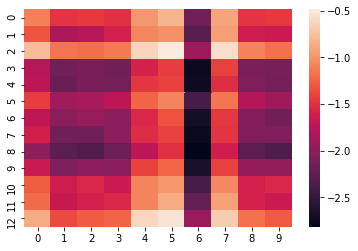

In [ ]:
class AttentionModule(nn.Module):
    """Realizes a very simple attention module. Takes last state and word into account with two-layer feedforward"""
    
    def __init__(self, embedding_dim, state_dim, hidden_dim, attention_type='general'):
        super(AttentionModule, self).__init__()

        if attention_type not in ['scaledot','general','additive','concat']:
            raise ValueError('Invalid attention type selected.')
        
        self.attention_type = attention_type
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.state_dim = state_dim
        
        self.output_layer = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(embedding_dim+state_dim, hidden_dim)),
            ('tanh', nn.Tanh()),
            ('dropout', nn.Dropout(0.5)),
            ('fc2', nn.Linear(hidden_dim, 1)),
            # ('fc', nn.Linear(embedding_dim+state_dim, 1)),
            ('sigmoid', nn.Sigmoid())
        ]))

        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self, word_embed, last_state):
       # word_embed = torch.LongTensor(word_embed)
       # word_embed = word_embed.to(device)

      # last_state = torch.LongTensor(last_state)
       # last_state = last_state.to(device)
      
        if self.attention_type == "scaledot":
            input_tensor = word_embed*last_state

            #input_tensor = torch.matmul([word_embed, last_state], dim=1)
            input_tensor = input_tensor / math.sqrt(self.hidden_dim)

        if self.attention_type == "general":
            input_tensor = torch.matmul([word_embed, last_state], dim=1)
    
        if self.attention_type == "additive":
            input_tensor = torch.add([word_embed, last_state], dim=1)
        
        if self.attention_type == "concat":
            input_tensor = torch.cat([word_embed, last_state], dim=1)
        
        for layer in self.output_layer:
            input_tensor = layer(input_tensor)
        
        return input_tensor
        

In [ ]:
class ACTLSTMClassifier(nn.Module):
    """Encodes sentence with a TreeLSTM and projects final hidden state"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab, attention_type):
        super(ACTLSTMClassifier, self).__init__()
        self.vocab = vocab
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.treelstm = ACTLSTM(embedding_dim, hidden_dim)
        
        self.attention_module = AttentionModule(embedding_dim, hidden_dim, embedding_dim, attention_type)

        self.attention_type = attention_type

        self.output_layer = nn.Sequential(     
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, output_dim, bias=True)
            )
        
        self.state_dropout = nn.Dropout(p=0.0)


    def forward(self, x):

        # x is a pair here of words and transitions; we unpack it here.
        # x is batch-major: [B, T], transitions is time major [2T-1, B]
        
        x, transitions = x

        B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
        T = x.size(1)  # time (the number of words in the sentence)
        emb = self.embed(x)


        # here we create initial hidden states containing zeros
        # we use a trick here so that, if input is on the GPU, then so are hx and cx
        hx = emb.new_zeros(B, self.treelstm.hidden_size)
        cx = emb.new_zeros(B, self.treelstm.hidden_size)

          # hx has dimension B,hidden_size -> need to be B,T,hidden_size
        exp_hx = hx.unsqueeze(dim=1).repeat([1,T,1])
        attent_hx_input = exp_hx.view((B * T, self.treelstm.hidden_size))
        attent_word_input = emb.view((B * T, self.embedding_dim))
        attention_scores = self.attention_module(attent_word_input, attent_hx_input)
        attention_scores = attention_scores.reshape(B,T,1)
        attentive_emb = attention_scores * emb
        #print("attention sores",attentive_emb.shape)
        #print("embedding", emb.shape)
        #print("transition", transitions.shape)
        #attention_scores = self.attention_module(emb,emb)
       # emb = attention_scores
        # we use the root/top state of the ACT LSTM to classify the sentence

        root_states = self.treelstm(attentive_emb, transitions)
       
      #  root_states = self.output_layer(last_final_states) / self.iterations


        # we use the last hidden state to classify the sentence
        logits = self.output_layer(root_states)
        return logits

In [ ]:
def random_attention_type():
  attention_type = torch.randint(1, 5, (1,))

  if attention_type[0] == 1:
    attention_type = "scaledot"
  if attention_type[0] == 2:
    attention_type = "general"
  if attention_type[0] == 3:
    attention_type = "additive"
  if attention_type[0] == 4:
   attention_type = "concat"
  
  return attention_type

## Training

In [ ]:
# Now let's train the Tree LSTM!

def get_tree_lstm():
    attention_type = random_attention_type()  
    tree_model = ACTLSTMClassifier(
        len(v.w2i), 300, 150, len(t2i), v, attention_type)

    with torch.no_grad():
       # tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        tree_model.embed.weight.requires_grad = True

    return tree_model
  
# results = do_train(tree_model)
train_model_default(get_tree_lstm, 2e-4, "ACTLSTM", batch_size=32, batch_fn=get_minibatch, prep_fn=prepare_treelstm_minibatch, eval_fn=evaluate, num_iterations=1000, eval_every=100)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Iter 83: loss=0.6744, time=11.38s
Iter 84: loss=0.6288, time=11.49s
Iter 85: loss=0.5959, time=11.64s
Iter 86: loss=0.6111, time=11.78s
Iter 87: loss=0.6384, time=11.92s
Iter 88: loss=0.5961, time=12.07s
Iter 89: loss=0.5582, time=12.19s
Iter 90: loss=0.6286, time=12.31s
Iter 91: loss=0.5432, time=12.44s
Iter 92: loss=0.6014, time=12.57s
Iter 93: loss=0.5292, time=12.67s
Iter 94: loss=0.6146, time=12.80s
Iter 95: loss=0.6307, time=12.95s
Iter 96: loss=0.5989, time=13.10s
Iter 97: loss=0.5605, time=13.21s
Iter 98: loss=0.5572, time=13.36s
Iter 99: loss=0.5932, time=13.51s
Iter 100: loss=0.5547, time=13.62s
iter 100: dev acc=0.7286
new highscore
Iter 101: loss=0.6137, time=14.08s
Iter 102: loss=0.6080, time=14.25s
Iter 103: loss=0.5582, time=14.41s
Iter 104: loss=0.4932, time=14.56s
Iter 105: loss=0.5570, time=14.69s
Iter 106: loss=0.5376, time=14.84s
Iter 107: loss=0.5492, time=15.01s
Iter 108: loss=0.6121, time=15.12s
Iter 109: loss=0.4496

In [ ]:
act_lstm_test_acc, act_lstm_val_acc, act_lstm_train_acc = eval_model_default(get_tree_lstm(), "ACTLSTM", batch_fn=get_minibatch, prep_fn=prepare_treelstm_minibatch, eval_fn=evaluate)

0.6785714285714286
0.6928571428571428
0.6714285714285714
0.6642857142857143
0.7357142857142858
0.7071428571428572
0.75
0.7642857142857142
0.7285714285714285
0.7714285714285715
0.7571428571428571
0.75
0.7357142857142858
0.6857142857142857
0.6642857142857143
0.7357142857142858
0.75
0.7928571428571428
0.7714285714285715
0.7571428571428571
0.7357142857142858
0.7571428571428571
0.7928571428571428
0.7214285714285714
0.7642857142857142
0.7785714285714286
0.7642857142857142
0.75
0.75
0.7571428571428571
0.75
0.7785714285714286
0.7428571428571429
0.8071428571428572
0.6857142857142857
0.6785714285714286
0.6428571428571429
0.7357142857142858
0.8071428571428572
0.7428571428571429
0.75
0.7571428571428571
0.75
0.7714285714285715
0.7642857142857142
0.7857142857142857
0.7857142857142857
0.7714285714285715
0.7642857142857142
0.7357142857142858
0.7357142857142858
0.7071428571428572
0.7428571428571429
0.7714285714285715
0.7857142857142857
0.8
0.6857142857142857
0.8
0.8
0.8
0.7071428571428572
0.73571428571

In [ ]:
print(mean(act_lstm_val_acc))

0.8356317011081166


In [ ]:
act_lstm_test_acc, act_lstm_val_acc, act_lstm_train_acc = eval_model_default2(get_tree_lstm(), "ACTLSTM", batch_fn=get_minibatch, prep_fn=prepare_treelstm_minibatch, eval_fn=evaluate)

In [ ]:
print(mean(act_lstm_val_acc))

0.7436428571428572


In [ ]:
with open('act_lstm_book_test_acc.txt', 'w') as f:
  for acc in act_lstm_test_acc:
    f.write(str(acc)+" ")

with open('act_lstm_book_val_acc.txt', 'w') as f:
  for acc in act_lstm_val_acc:
    f.write(str(acc)+" ")

with open('act_lstm_book_train_acc.txt', 'w') as f:
  for acc in act_lstm_train_acc:
    f.write(str(acc)+" ")

In [ ]:
print(mean(act_lstm_train_acc))

0.9276205450733751


In [ ]:
#plt.plot(results[1])

In [ ]:
model = get_tree_lstm()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
_,tree_lstm_single_run_accuracies,_ = train_model(
    model, optimizer, num_iterations=1000, 
    print_every=100, eval_every=100, batch_size = 32, file_prefix="TreeLSTM_EvalRun",batch_fn=get_minibatch, 
    prep_fn=prepare_treelstm_minibatch,eval_fn=evaluate, dataset_train=train_data)

del model
del optimizer
torch.cuda.empty_cache()  